# Prologue

<hr>

__Для подключения к API octoparts.com используется протокол OAuth2. Подключение осуществляется через оболочку nexar с использованием запросов на GraphQL. Для общения с этим сервисом я написал простой класс OctopartParser, файл с которым лежит в папке с этим ноутбуком. OctopartParser может получить токен от nexar, инициализировать сессию и выполнить некоторые базовые запросы к БД (получить данные о продавцах, категориях, отдельных деталях и т.д.). Nexar - это платный сервис с ограничением на 1000 бесплатных запросов. Поэтому я проведу анализ, например, тысячи первых микроконтроллеров, так как больших данных в связи с ограничением я получить не могу.__

In [288]:
import pandas as pd
import numpy as np

# created class OctoParser
import octopart_parcer
from octopart_parcer import OctopartParser
# created class to collect data from Yandex-disk
import data_preprocessing
from data_preprocessing import DataCollector

import re
from ast import literal_eval

import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

__Initializing the session__

In [ ]:
client_ID = '053e9f3c-85b2-4285-a1e3-fdf02d375b29'
client_secret = '05c3383d-46d9-4035-bbaf-2cc18635386d'

octopart_session = OctopartParser(client_id=client_ID, client_secret=client_secret)

In [ ]:
categories = octopart_session.get_all_categories(file_name='categories.csv')
sellers = octopart_session.get_all_sellers('sellers.csv')
manufacturers = octopart_session.get_all_manufacturers('manufacturers.csv')

In [ ]:
# take info about 1000 microcontrollers
parts = pd.DataFrame()
for _ in list(range(100, 1001, 100)):
    part = octopart_session.get_parts_by_query(q='microcontrollers', start=_, file_name=f'part_{_}.csv')
    parts = pd.concat([parts, part])

In [ ]:
parts = pd.DataFrame(parts.part.to_list())

<hr>

## Analisys


__I uploaded the parsed information to the yandex-disk, because I've reached the query-quantity limit on nexar and repeated requests are unavailable. But it is possible to create a code performing all ETL-cycle automatically if there is no query-limit.__

In [163]:
# download data
# _____________________________________________________________________________________________________________________________

In [164]:
parts = DataCollector().get_zip_yandex_disk('https://disk.yandex.ru/d/thq48EM_REwTCQ')\
                       .read_data()\
                       .concat_parts()\
                       .get_data()

zip file contains ['part_1000.csv', 'part_200.csv', 'part_300.csv', 'part_400.csv', 'part_500.csv', 'part_600.csv', 'part_700.csv', 'part_800.csv', 'part_900.csv', 'part_100.csv']


In [165]:
octopart_zip = DataCollector().get_zip_yandex_disk('https://disk.yandex.ru/d/93XVSDXU0PAZqw')\
                              .read_data()

zip file contains ['sellers.csv', 'categories.csv', 'manufacturers.csv']


In [166]:
sellers = octopart_zip.get_data(file_name='sellers')
categories = octopart_zip.get_data(file_name='categories')
manufacturers = octopart_zip.get_data(file_name='manufacturers')

In [167]:
# parts
# ______________________________________________________________________________________________________________________________

In [168]:
parts.head(3)

,Unnamed: 0,description,part
0,0,"ARM9® SAM9XE <em class=""highlight"">Microcontro...","{'category': {'id': '4299'}, 'estimatedFactory..."
1,1,"Add-On Board, Pic32 <em class=""highlight"">Micr...","{'category': {'id': '4267'}, 'estimatedFactory..."
2,2,"Precision Analog <em class=""highlight"">Microco...","{'category': {'id': '4300'}, 'estimatedFactory..."


In [169]:
# categories
# ______________________________________________________________________________________________________________________________

In [170]:
categories.head(3)

,Unnamed: 0,id,name,path,numParts,parentId,children,relevantAttributes
0,0,4161,Electronic Parts,/electronic-parts,24283237,NaN,"[{'id': '4393'}, {'id': '4569'}, {'id': '4364'...",[]
1,1,4393,Cables and Wire,/electronic-parts/cables-and-wire,647281,4161.0,"[{'id': '5031'}, {'id': '4394'}, {'id': '4399'...","[{'id': '712'}, {'id': '572'}, {'id': '275'}, ..."
2,2,5031,Audio / Video Cables,/electronic-parts/cables-and-wire/audio-video-...,7862,4393.0,[],"[{'id': '712'}, {'id': '737'}, {'id': '830'}, ..."


In [171]:
# manufaturers
# ______________________________________________________________________________________________________________________________

In [172]:
manufacturers.head()

,Unnamed: 0,id,name,homepageUrl,displayFlag,isDistributorApi,isVerified
0,0,12587,2-Power,https://2-power.com/,NaN,False,False
1,1,3739,2E Mechatronic,http://www.2e-mechatronic.de/,NaN,False,False
2,2,7674,2J,NaN,NaN,False,False
3,3,11375,2K Games,https://www.2k.com/,NaN,False,False
4,4,7042,2WIRE,NaN,NaN,False,False


__Need to transform a colnames and extract a dict-like data from the cells__

In [173]:
def transform_colnames(colname):
    re1 = r'[A-Z]{1}[a-z]+'
    re2 = r'[a-z]+'
    re3 = r'[A-Z]{2,}'
    
    colname_list = re.compile("%s|%s|%s" % (re1, re2, re3)).findall(colname)
    colname = ''
    for i in colname_list:
        if i.isupper():
            colname = colname + i + '_'
        else:        
            colname = colname + i.lower() + '_'
    return colname[:-1]

def get_info(df):
    info_df = pd.DataFrame()
    info_df['col_name'] = df.columns.to_list()
    info_df['dtype'] = df.dtypes.to_list()
    info_df['missing_values'] = df.isna().sum().to_list()
    info_df['unique_vals'] = df.nunique().to_list()
    info_df['total_vals'] = df.shape[0]
    return info_df



In [174]:
parts = pd.DataFrame(parts.part.apply(literal_eval).to_list())
parts.head(2)

,category,estimatedFactoryLeadDays,id,manufacturer,medianPrice1000,mpn,name
0,{'id': '4299'},112.0,77759171,{'id': '252'},"{'convertedPrice': 21.58, 'conversionRate': 1,...",AT91SAM9XE512B-CU,Microchip AT91SAM9XE512B-CU
1,{'id': '4267'},35.0,117437924,{'id': '3764'},"{'convertedPrice': 68, 'conversionRate': 1, 'c...",MIKROE-4591,mikroElektronika MIKROE-4591


In [175]:
# first of all, lets look data to figure out how much missing values it is
parts.isna().sum()

category                    17
estimatedFactoryLeadDays    47
id                           0
manufacturer                 0
medianPrice1000             13
mpn                          0
name                         0
dtype: int64

In [176]:
# remove missing values
parts = parts.dropna().reset_index(drop=True)
# extract dict-like info from median_price
parts = pd.concat([parts, pd.DataFrame(parts.medianPrice1000.to_list())], axis=1)
# extract category and manufacturer id
parts['category_id'] = parts.category.apply(pd.Series).astype(int)
parts['manufacturer_id'] = parts.category.apply(pd.Series).astype(int)
# drop unnecessary columns
parts = parts.drop(columns=['category', 'manufacturer','medianPrice1000', 
                            'convertedPrice', 'conversionRate', 'convertedCurrency'])
categories = categories.rename(columns={'id': 'category_id', 'name': 'category_name'})
manufacturers = manufacturers.rename(columns={'id': 'manufacturer_id', 'name': 'manufacturer_name'})


parts = pd.merge(left=parts, right=categories[['category_id', 'category_name']], on='category_id', how='inner')\
          .merge(manufacturers[['manufacturer_id', 'manufacturer_name']], on='manufacturer_id', how='inner')

# transform colnames
parts.columns = parts.columns.map(transform_colnames)

In [178]:
parts.head(3)

,estimated_factory_lead_days,id,mpn,name,currency,price,quantity,category_id,manufacturer_id,category_name,manufacturer_name
0,112.0,77759171,AT91SAM9XE512B-CU,Microchip AT91SAM9XE512B-CU,USD,21.58000,1000,4299,4299,Microprocessors,Video Display Corporation
1,182.0,33923139,LPC1768FET100Y,NXP Semiconductors LPC1768FET100Y,USD,11.50292,1000,4299,4299,Microprocessors,Video Display Corporation
2,182.0,10459874,"LPC2460FBD208,551","NXP Semiconductors LPC2460FBD208,551",USD,12.87580,1000,4299,4299,Microprocessors,Video Display Corporation


In [179]:
get_info(parts)

,col_name,dtype,missing_values,unique_vals,total_vals
0,estimated_factory_lead_days,float64,0,54,934
1,id,object,0,826,934
2,mpn,object,0,826,934
3,name,object,0,826,934
4,currency,object,0,1,934
5,price,float64,0,781,934
6,quantity,int64,0,1,934
7,category_id,int32,0,7,934
8,manufacturer_id,int32,0,7,934
9,category_name,object,0,7,934


__So, there is two columns interested us: price and estimated_factory_lead_days. These are the numeric metrics we could compare on all parts. Let's formulate a couple tasks:__

1. __Find a most expensive an most cheap part, mean, median price for each category/manufacturer.__
2. __Obtain top-3 manufacturers list by total quantity of parts manufactured.__
3. __Plot distributions of numeric vals.__

__There are could be founded much more aspects to analyze, but this list is enough to demonstrate the basics of data analysis and visualization.__


__Ok, here we are!__


<hr>

### 1. Find a most expensive an most cheap part, mean, median price for each category/manufacturer.

In [215]:
def group_analisys(df, group_by): 
    
    df_spec = df.groupby(group_by, as_index=False)\
                .agg({'id': 'nunique'})\
                .rename(columns={'id': 'unique_parts'})

    df_spec['mean_price'] = df.groupby(group_by, as_index=False)\
                              .agg({'price': 'mean'})['price']

    df_spec['median_price'] = df.groupby(group_by, as_index=False)\
                                .agg({'price': 'median'})['price']
    
    exp_part = parts.groupby([group_by, 'name'], as_index=False)\
                    .agg({'price': 'max'})\
                    .sort_values(by='price', ascending=False)\
                    .drop_duplicates(subset=group_by, keep='first')\
                    .rename(columns={'name': 'most_expensive_part', 'price': 'max_price'})
    
    cheap_part = parts.groupby([group_by, 'name'], as_index=False)\
                      .agg({'price': 'min'})\
                      .sort_values(by='price', ascending=True)\
                      .drop_duplicates(subset=group_by, keep='first')\
                      .rename(columns={'name': 'cheapest_part', 'price': 'min_price'})

    df_spec = df_spec.merge(exp_part, on=group_by).merge(cheap_part, on=group_by)
    
    return df_spec

In [217]:
by_categ = group_analisys(parts, 'category_name')
by_manuf = group_analisys(parts, 'manufacturer_name')

In [220]:
# categories sorted by mean_price (descending)
by_categ.sort_values(by='mean_price', ascending=False)

,category_name,unique_parts,mean_price,median_price,most_expensive_part,max_price,cheapest_part,min_price
6,RF Semiconductors and Devices,5,505.791200,331.170000,onsemi AXM0F343-64-915-1-GEVK,902.0830,Microchip ATSAMR21-XPRO,82.37000
1,Embedded Processors and Controllers,44,255.748721,77.765000,STMicroelectronics SPC58XXMB,1259.2000,Silicon Labs EFM32TG11B340F64GQ64-B,2.94000
0,Circuit Breakers,2,106.266000,106.266000,Microchip ATATMEL-ICE-BASIC,130.6820,Microchip ATATMEL-ICE-PCBA,81.85000
2,Integrated Circuits (ICs),1,69.615000,69.615000,Microchip AC244055,69.6150,Microchip AC244055,69.61500
4,Microcontrollers,761,7.875526,5.020000,Analog Devices EV-ADUCRF101QSP1Z,186.4900,Microchip ATTINY212-SSF,0.44908
5,Microprocessors,12,5.644062,3.085745,Microchip AT91SAM9XE512B-CU,21.5800,Microchip PIC10LF320-I/P,0.72100
3,Interface ICs,1,5.026400,5.026400,Grayhill GH65C11-N-SO,5.0264,Grayhill GH65C11-N-SO,5.02640


In [221]:
# manufacturers sorted by unique_parts (ascending)
by_categ.sort_values(by='mean_price', ascending=True)

,category_name,unique_parts,mean_price,median_price,most_expensive_part,max_price,cheapest_part,min_price
3,Interface ICs,1,5.026400,5.026400,Grayhill GH65C11-N-SO,5.0264,Grayhill GH65C11-N-SO,5.02640
5,Microprocessors,12,5.644062,3.085745,Microchip AT91SAM9XE512B-CU,21.5800,Microchip PIC10LF320-I/P,0.72100
4,Microcontrollers,761,7.875526,5.020000,Analog Devices EV-ADUCRF101QSP1Z,186.4900,Microchip ATTINY212-SSF,0.44908
2,Integrated Circuits (ICs),1,69.615000,69.615000,Microchip AC244055,69.6150,Microchip AC244055,69.61500
0,Circuit Breakers,2,106.266000,106.266000,Microchip ATATMEL-ICE-BASIC,130.6820,Microchip ATATMEL-ICE-PCBA,81.85000
1,Embedded Processors and Controllers,44,255.748721,77.765000,STMicroelectronics SPC58XXMB,1259.2000,Silicon Labs EFM32TG11B340F64GQ64-B,2.94000
6,RF Semiconductors and Devices,5,505.791200,331.170000,onsemi AXM0F343-64-915-1-GEVK,902.0830,Microchip ATSAMR21-XPRO,82.37000


<hr>

### 2. Obtain top-3 manufacturers list by total quantity of parts manufactured.

In [226]:
top_3_manuf = parts.groupby(by='manufacturer_name', as_index=False)\
                   .agg({'id': 'count'})\
                   .sort_values(by='id', ascending=False)\
                   .rename(columns={'id': 'number_of_parts'})\
                   .head(3)

top_3_manuf

,manufacturer_name,number_of_parts
3,Silicon Motion,861
2,PB Swiss Tools,52
6,Video Display Corporation,12


<hr>

### 3. Plot distributions of numeric vals.

In [281]:
def density_distribution(data_column, plot_title:str, show_info=True, conf_level=0.95):
#   quantiles
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level)/2
    quants = data_column.quantile([left_quant, right_quant])

#   visualization
    if show_info is True:    
        plt.figure(figsize=(12, 5))
        fig_1 = plt.subplot(1, 2, 1)
        _, _, bars = plt.hist(data_column, bins = 30)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0] or bar.get_x() >= quants.iloc[1]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('seaborn-whitegrid')
        plt.vlines(quants,ymin=0,ymax=(len(data_column)*0.06),colors='red',linestyle='--')
        plt.vlines(data_column.mean(),ymin=0,ymax=(len(data_column)*0.06),colors='yellow',linestyle='--')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        plt.title(f'{plot_title}\n')
        fig_2 = plt.subplot(1, 2, 2)
        ss.probplot(data_column, plot=plt)
        plt.title(f'{plot_title} QQ-plot\n')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        plt.show()
    
#   Shapiro and D'Agostino normtest
    shapiro_result = ss.shapiro(data_column)
    dagostino_result = ss.normaltest(data_column)
    if ((shapiro_result[1] >= 0.05) & (dagostino_result[1] >= 0.05)):
        if show_info is True:
            print(f'{plot_title} has normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}' )
        return True
    else:
        if show_info is True:
            print(f'{plot_title} has not normal probability density distribution\n Shapiro test p-val {shapiro_result[1]}\n Dagostino p-val {dagostino_result[1]}')
        return False

__There is several ways to visualize distribution of the numeric data. I want to use boxplot, violinplot and histplot to visualize price distribution in Microcontrollers-group since this group is largest__

__Box plot__

In [298]:
plt.figure(figsize=(10, 8))

fig = go.Figure()

# cats = ['Microcontrollers', 'Embedded Processors and Controllers']

fig.add_trace(go.Box(x=parts['price'][parts.category_name == 'Microcontrollers'],
                         name='Microcontrollers'))

fig.update_yaxes(title='y', visible=False, showticklabels=False)
fig.show()

<Figure size 720x576 with 0 Axes>

__Violin plot__

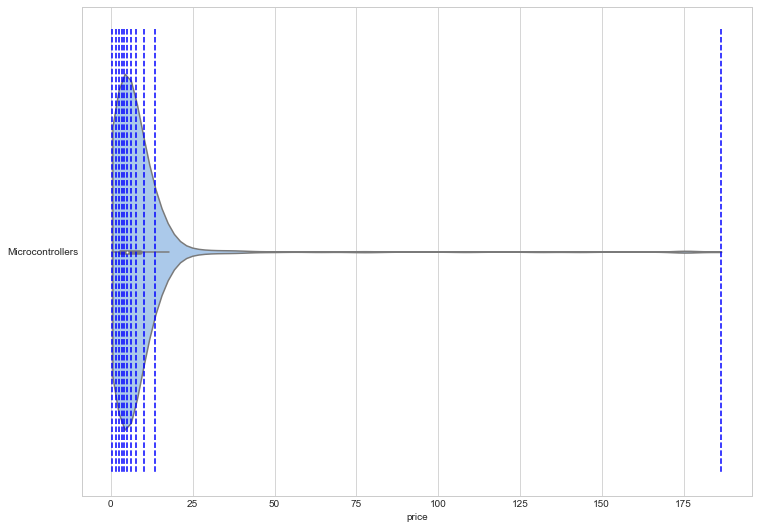

In [297]:
plt.figure(figsize=(12, 9))
plt.style.use('seaborn-whitegrid')

# cats = ['Microcontrollers', 'Embedded Processors and Controllers']
quantiles = list(np.arange(0.0, 1.1, 0.1))

sns.violinplot(data=parts[parts.category_name == 'Microcontrollers'], 
               x='price', y='category_name', inner='box', cut=0, palette='pastel')
plt.ylabel(None)


for q in quantiles:
    plt.vlines(parts['price'][parts.category_name == 'Microcontrollers'].quantile(q),
               ymin=-0.5,ymax=0.5,colors='b',linestyle='--')

plt.show()

__Histplot (and normality-test simultaneously)__

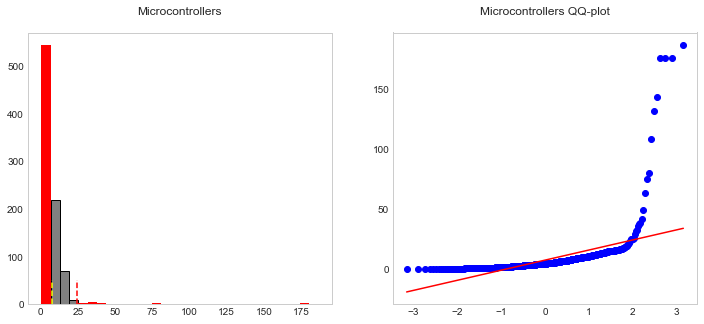

Microcontrollers has not normal probability density distribution
 Shapiro test p-val 0.0
 Dagostino p-val 9.058681043994777e-279


False

In [299]:
density_distribution(parts['price'][parts.category_name == 'Microcontrollers'], 
                     plot_title='Microcontrollers')

__Both parametric and non-parametric test showed distribution is not normal (not to mention it's obviously from plots).__

__It has Right-skewed Fisher's distribution (as is usually the case with prices)__